In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import AUC, Precision, Recall
import pickle
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [33]:
# Charge X and y data that are in .npy format
X = np.load('../save_model/X.npy')
y = np.load('../save_model/y.npy')
X.shape, y.shape

((241, 300, 30), (241,))

In [34]:
# Divide data in train, val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
#X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

In [20]:
def augment_sequence(x, noise_std=0.01, max_shift=5, scale_range=(0.9, 1.1), window_size=10):
    """
    Aplica aumento de datos a una secuencia individual de forma (300, 30)
    """
    # 1. Agregar ruido gaussiano
    noise = np.random.normal(0, noise_std, x.shape)
    x_aug = x + noise

    # 2. Desplazamiento temporal (shift)
    shift = np.random.randint(-max_shift, max_shift + 1)
    x_aug = np.roll(x_aug, shift, axis=0)

    # 3. Escalado
    scale = np.random.uniform(scale_range[0], scale_range[1])
    x_aug = x_aug * scale

    # 4. Permutación de subventanas
    num_segments = x.shape[0] // window_size
    segments = np.array_split(x_aug[:num_segments * window_size], num_segments, axis=0)
    np.random.shuffle(segments)
    x_aug = np.concatenate(segments, axis=0)

    return x_aug


def augment_dataset(X, y, augment_factor=2):
    """
    Aumenta el dataset X, y multiplicando los datos por augment_factor
    """
    X_aug = []
    y_aug = []

    for i in range(len(X)):
        for _ in range(augment_factor):
            x_new = augment_sequence(X[i])
            X_aug.append(x_new)
            y_aug.append(y[i])

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    
    # Mezclamos con los originales si quieres:
    X_combined = np.concatenate([X, X_aug], axis=0)
    y_combined = np.concatenate([y, y_aug], axis=0)

    return X_combined, y_combined

In [21]:
X_train_augmented, y_train_augmented = augment_dataset(X_train, y_train, augment_factor=9)
print(X_train_augmented.shape)  # Debería ser (241 * 3, 300, 30)
print(y_train_augmented.shape)

(1530, 300, 30)
(1530,)


In [22]:
X_train_augmented.shape, y_train_augmented.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1530, 300, 30), (1530,), (39, 300, 30), (39,), (49, 300, 30), (49,))

In [35]:
# Calcular pesos automáticamente
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [36]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from torch.utils.data import TensorDataset, DataLoader

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = weight_norm(nn.Conv1d(in_channels, out_channels, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(out_channels, out_channels, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        if self.downsample is not None:
            nn.init.kaiming_normal_(self.downsample.weight)

    def forward(self, x):
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.chomp2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                     dilation=dilation_size, padding=(kernel_size - 1) * dilation_size,
                                     dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCNClassifier(nn.Module):
    def __init__(self, input_size=30, num_classes=4, num_channels=[64, 128, 128], kernel_size=3, dropout=0.3):
        super().__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout)
        self.fc = nn.Linear(num_channels[-1], num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        x = x.permute(0, 2, 1)  # (batch_size, input_size, seq_len)
        y = self.tcn(x)         # (batch_size, num_channels[-1], seq_len)
        y = y[:, :, -1]         # Tomamos el último time step
        return self.fc(y)

In [37]:
def make_loader(X_np, y_np, batch_size=32, shuffle=False):
    X_t = torch.tensor(X_np, dtype=torch.float32)
    y_t = torch.tensor(y_np, dtype=torch.long)
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train, shuffle=True)
val_loader = make_loader(X_val, y_val)
test_loader = make_loader(X_test, y_test)

In [38]:
model = TCNClassifier(input_size=30, num_classes=4)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

best_val_loss = float('inf')
patience = 5
counter = 0
best_model = None

for epoch in range(50):  # Hasta 50 epochs con early stopping
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping.")
            break

# Cargar el mejor modelo
model.load_state_dict(best_model)

d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\env\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 1 | Train Loss: 1.4174 | Val Loss: 1.3816
Epoch 2 | Train Loss: 1.3946 | Val Loss: 1.4080
Epoch 3 | Train Loss: 1.3688 | Val Loss: 1.3697
Epoch 4 | Train Loss: 1.3629 | Val Loss: 1.3706
Epoch 5 | Train Loss: 1.3455 | Val Loss: 1.3720
Epoch 6 | Train Loss: 1.3337 | Val Loss: 1.3897
Epoch 7 | Train Loss: 1.2985 | Val Loss: 1.3734
Epoch 8 | Train Loss: 1.2889 | Val Loss: 1.3728
Early stopping.


<All keys matched successfully>

In [39]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        pred_labels = preds.argmax(dim=1).cpu().numpy()
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(pred_labels)

print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

Test Accuracy: 0.24489795918367346
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.17      0.22        12
           1       0.50      0.08      0.14        12
           2       0.00      0.00      0.00        13
           3       0.25      0.75      0.38        12

    accuracy                           0.24        49
   macro avg       0.27      0.25      0.19        49
weighted avg       0.27      0.24      0.18        49



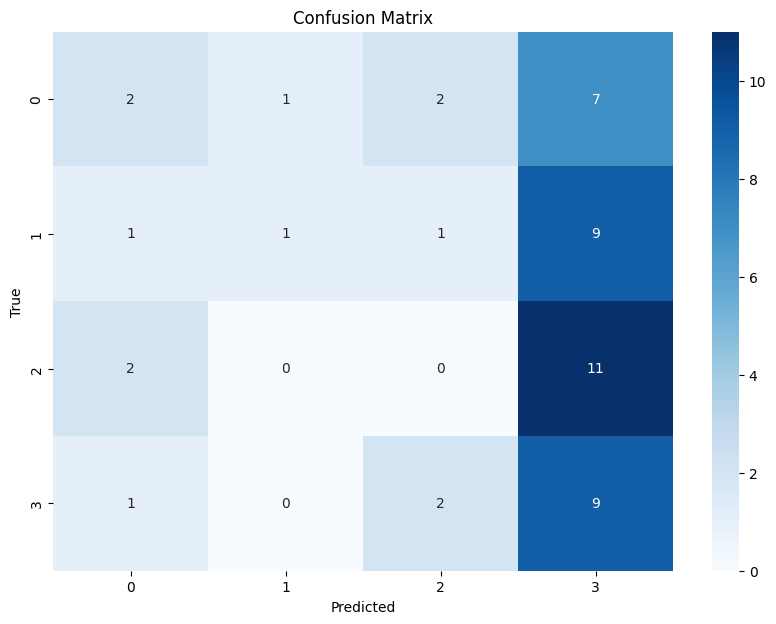

In [40]:
# i want ot view the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# Compute confusion matrix in a heatmap
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=[0, 1, 2, 3], columns=[0, 1, 2, 3])
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
